# Equation Discovery with Symbolic Regression to Paramterize Heat Flux in the Atmospheric Boundary Layer

*Authors: Antony Sikorski*

This notebook should make it easy to perform equation discovery with the use of the function `discover_eqs`. 

This function uses a number of supporting functions from the accompanying `functions.py` file, and should output a dataframe of possible equations.

We use the `PySR` package for symbolic regression, an ML method for finding interpretable symbolic expressions.

In [3]:
#importing libraries
# from pdfs import *
import os
import re

import xarray as xr
import netCDF4 as nc
import h5netcdf

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

import pysr
from pysr import PySRRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from functions import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Some quick data processing: 

In [4]:
path = 'C:/Users/anton/Desktop/Career/LEAP_nyc_Summer2024/les_sim_2/'

directories, items = list_directories_files(path)
print("Directories starting with 'Ug':", directories)
print("Files starting with 'Ug':", items)

Directories starting with 'Ug': []
Files starting with 'Ug': ['Ug16Q000_IV.nc', 'Ug16Q001_IV.nc', 'Ug16Q003_IV.nc', 'Ug16Q006_I.nc', 'Ug16Q006_IV.nc', 'Ug16Q010_IV.nc', 'Ug1Q01_II.nc', 'Ug2Q010_I.nc', 'Ug2Q010_IV.nc', 'Ug2Q01_III.nc', 'Ug2Q024_I.nc', 'Ug8Q003_II.nc', 'Ug8Q003_III.nc', 'Ug8Q003_IV.nc', 'Ug8Q006_IV.nc']


In [5]:
for item in items:
    ds_stat = nc.Dataset( os.path.join(path, item), mode='r')
    if 'budget' in ds_stat.groups:
        print ("budget is in", item)
    else:
        print ("budget is not in", item)

budget is not in Ug16Q000_IV.nc
budget is in Ug16Q001_IV.nc
budget is in Ug16Q003_IV.nc
budget is in Ug16Q006_I.nc
budget is in Ug16Q006_IV.nc
budget is in Ug16Q010_IV.nc
budget is in Ug1Q01_II.nc
budget is in Ug2Q010_I.nc
budget is in Ug2Q010_IV.nc
budget is in Ug2Q01_III.nc
budget is in Ug2Q024_I.nc
budget is in Ug8Q003_II.nc
budget is in Ug8Q003_III.nc
budget is in Ug8Q003_IV.nc
budget is in Ug8Q006_IV.nc


In [6]:
for item in items[1:]:
    print(item)
    df = nc.Dataset(path + '/' + item, mode='r')
    print(df)

Ug16Q001_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q003_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q006_I.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(256), zh(257), time(120)
    variables(dimensions): float64 time(time), float64 z(z), float64 zh(zh)
    groups: default, thermo, budget
Ug16Q006_IV.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(384), zh(385), time(90)
    variables(dimensions): float64 time(time), float64 z(z), f

In [7]:
target_z_dim = 384

selected_files = []

for item in items[1:]:
        df = nc.Dataset(os.path.join(path, item), mode='r')
        if df.dimensions['z'].size == target_z_dim:
            selected_files.append(item)
        df.close()


print("Total number of files: ", len(items))
print("Number of valid files (same z and zh dims): ", len(selected_files))
print("Valid files: ", selected_files)

Total number of files:  15
Number of valid files (same z and zh dims):  11
Valid files:  ['Ug16Q001_IV.nc', 'Ug16Q003_IV.nc', 'Ug16Q006_IV.nc', 'Ug16Q010_IV.nc', 'Ug1Q01_II.nc', 'Ug2Q010_IV.nc', 'Ug2Q01_III.nc', 'Ug8Q003_II.nc', 'Ug8Q003_III.nc', 'Ug8Q003_IV.nc', 'Ug8Q006_IV.nc']


In [8]:
# eqs_hard_1 = discover_eqs(path, selected_files, time_avg = 15, indices = np.s_[:, 0:200], difficulty = "hard", normChoice = "none")
# eqs_hard_2 = discover_eqs(path, selected_files, time_avg = 15, indices = np.s_[:, 0:200], difficulty = "hard", normChoice = "none")

In [9]:
# display(eqs_hard_1)
# display(eqs_hard_2)

In [10]:
# display(eqs_hard_1.iloc[4,4])
# display(eqs_hard_2.iloc[4,4])

In [11]:
df_coefs = pd.DataFrame(columns = ['File', 'Avg Ustar', 'Avg Tau', 'Ug', 'Q', 'RMSE', 'R2', 'C1', 'C2', 'C3'])

for item in selected_files:
    #file
    # print(item)
    ds_stat = nc.Dataset(os.path.join(path, item), mode='r')

    #ustar
    ustar = ds_stat.groups['default'].variables['ustar'][:]
    # print("Mean of ustar: ", np.mean(ustar))

    #tau
    grr = 9.8
    T_0 = 300
    beta = grr/T_0
    pbl_height = ds_stat.groups['thermo'].variables['zi'][:]
    wtheta_surface = ds_stat.groups['thermo']['th_flux'][:,0]  
    wstar = np.power( beta * (wtheta_surface) * pbl_height , 1/3) 
    tau = pbl_height/wstar
    # print("Mean of tau: ", np.mean(tau))

    #ug and q
    ug, q = extract_ug_q(item)
    # print("Ug: ", ug)
    # print("Q: ", q)

    #rmse, r2
    fitted_model, X_train, X_test, y_train, y_test, rmse, r2, coefficients = LES_linear_regressor(path, [item], 
                                                                                                  time_avg = 15, 
                                                                                                  indices = np.s_[:, 0:200], 
                                                                                                  verbose = False)
    
    #c1, c2, c3
    c1 = coefficients[0]
    c2 = coefficients[1]
    c3 = coefficients[2]

    # Create a new row to be appended
    new_row = {
        'File': item,
        'Avg Ustar': np.mean(ustar),
        'Avg Tau': np.mean(tau),
        'Ug': ug,
        'Q': q,
        'RMSE': rmse,
        'R2': r2,
        'C1': c1,
        'C2': c2,
        'C3': c3
    }

    # Append the new row to the DataFrame
    df_coefs = pd.concat([df_coefs, pd.DataFrame([new_row])], ignore_index=True)

    # print("")

C:\Users\anton\AppData\Local\Temp\ipykernel_7048\3900646949.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coefs = pd.concat([df_coefs, pd.DataFrame([new_row])], ignore_index=True)


In [12]:
df_coefs['Inversion Strength'] = [4, 4, 4, 4, 2, 4, 3, 2, 3, 4, 4]
df_coefs['C1'] = df_coefs['C1']* df_coefs['Avg Tau']
df_coefs['C2'] = df_coefs['C2']/beta
df_coefs['C1'] = np.abs(df_coefs['C1'])
df_coefs['C2'] = np.abs(df_coefs['C2'])
df_coefs['C3'] = np.abs(df_coefs['C3'])

In [13]:
df_coefs

,File,Avg Ustar,Avg Tau,Ug,Q,RMSE,R2,C1,C2,C3,Inversion Strength
0,Ug16Q001_IV.nc,0.583217,1405.862176,16,1,0.000024,0.981304,0.534015,0.971441,0.931903,4
1,Ug16Q003_IV.nc,0.619608,1049.518786,16,3,0.000056,0.968710,2.200838,0.794898,0.608740,4
2,Ug16Q006_IV.nc,0.663322,843.801678,16,6,0.000076,0.967333,3.480432,0.667441,0.352913,4
3,Ug16Q010_IV.nc,0.692744,753.947342,16,10,0.000064,0.986968,3.892732,0.635783,0.275732,4
4,Ug1Q01_II.nc,0.156549,685.283322,1,1,0.000081,0.990494,1.160933,0.772905,0.447008,2
5,Ug2Q010_IV.nc,0.185135,721.373486,2,10,0.000060,0.985244,1.130810,0.739922,0.519088,4
6,Ug2Q01_III.nc,0.184706,703.534752,2,1,0.000072,0.988998,1.330275,0.773037,0.461213,3
7,Ug8Q003_II.nc,0.384079,923.887276,8,3,0.000030,0.990180,2.158704,0.775836,0.398563,2
8,Ug8Q003_III.nc,0.383418,939.150159,8,3,0.000026,0.988617,2.686453,0.735105,0.312753,3
9,Ug8Q003_IV.nc,0.387227,980.796441,8,3,0.000023,0.987343,3.306518,0.693531,0.299167,4


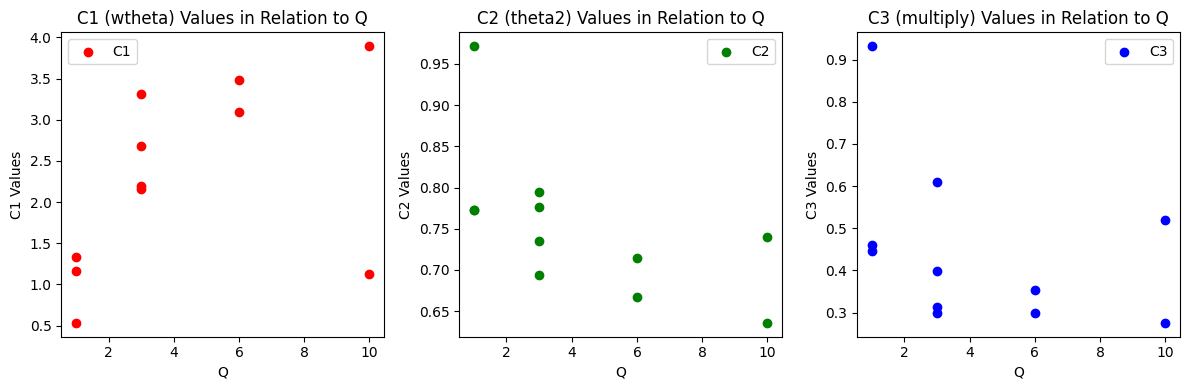

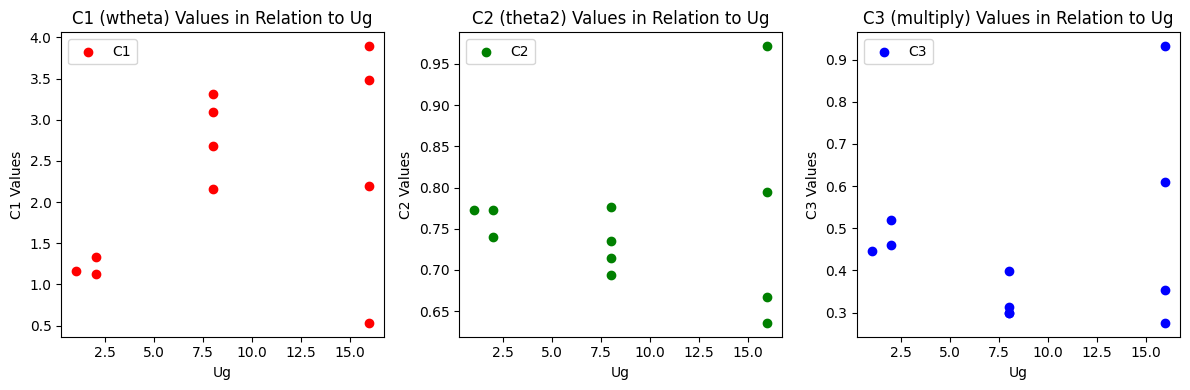

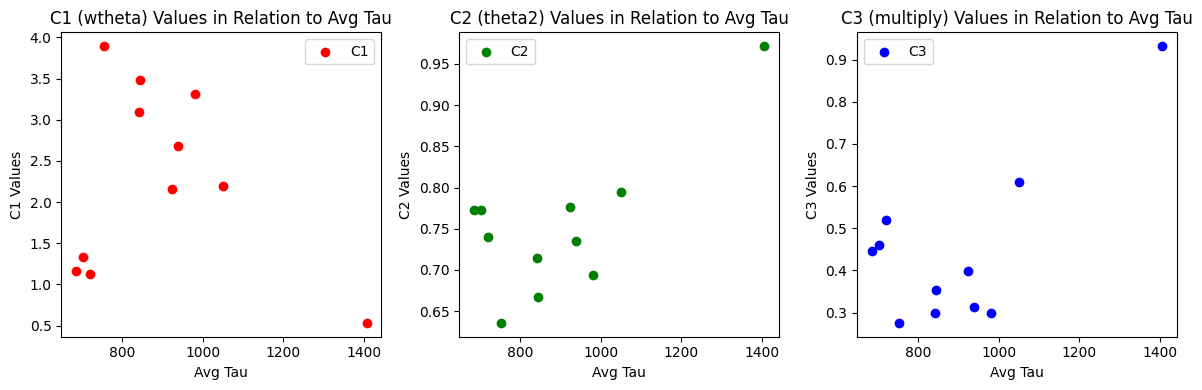

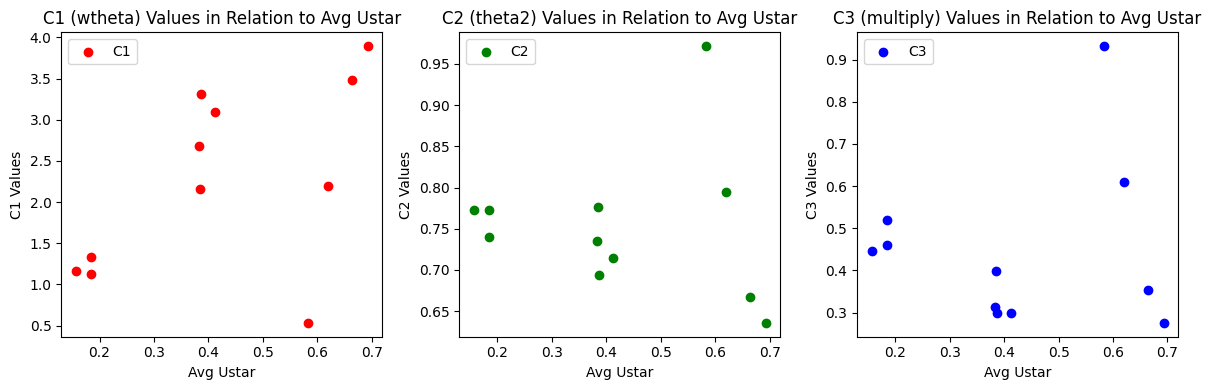

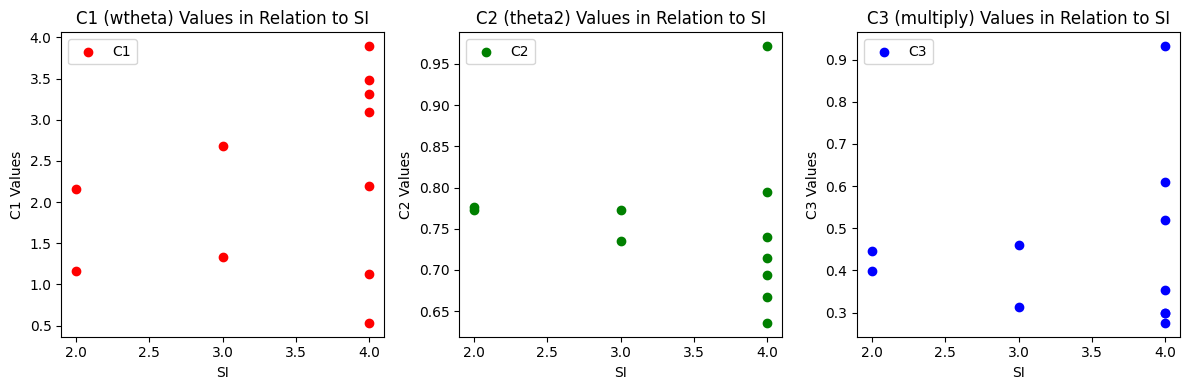

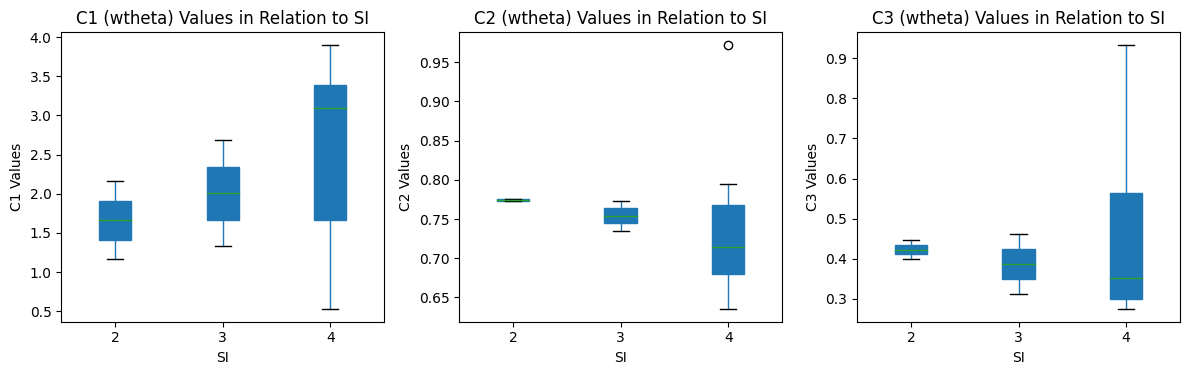

In [14]:
# Define the variables and their respective labels and colors
variables = ['Q', 'Ug', 'Avg Tau', 'Avg Ustar', 'Inversion Strength']
xlabels = ['Q', 'Ug', 'Avg Tau', 'Avg Ustar', 'SI']
titles = [
    'C1 (wtheta) Values in Relation to {}', 
    'C2 (theta2) Values in Relation to {}', 
    'C3 (multiply) Values in Relation to {}'
]
colors = ['red', 'green', 'blue']
columns = ['C1', 'C2', 'C3']

# Loop through each variable to create scatter plots
for var, xlabel in zip(variables, xlabels):
    plt.figure(figsize=(12, 4))
    
    for i, (col, color, title) in enumerate(zip(columns, colors, titles)):
        plt.subplot(1, 3, i + 1)
        plt.scatter(df_coefs[var], df_coefs[col], label=col, marker='o', color=color)
        plt.xlabel(xlabel)
        plt.ylabel(f'{col} Values')
        plt.title(title.format(xlabel))
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Special case for box plots for 'Inversion Strength'
plt.figure(figsize=(12, 4))

for i, col in enumerate(columns):
    plt.subplot(1, 3, i + 1)
    df_coefs.boxplot(column=col, by='Inversion Strength', grid=False, ax=plt.gca(), patch_artist=True)
    plt.xlabel('SI')
    plt.ylabel(f'{col} Values')
    plt.title(f'{col} (wtheta) Values in Relation to SI')
    plt.suptitle('')  # Suppress the automatic title

plt.tight_layout()
plt.show()


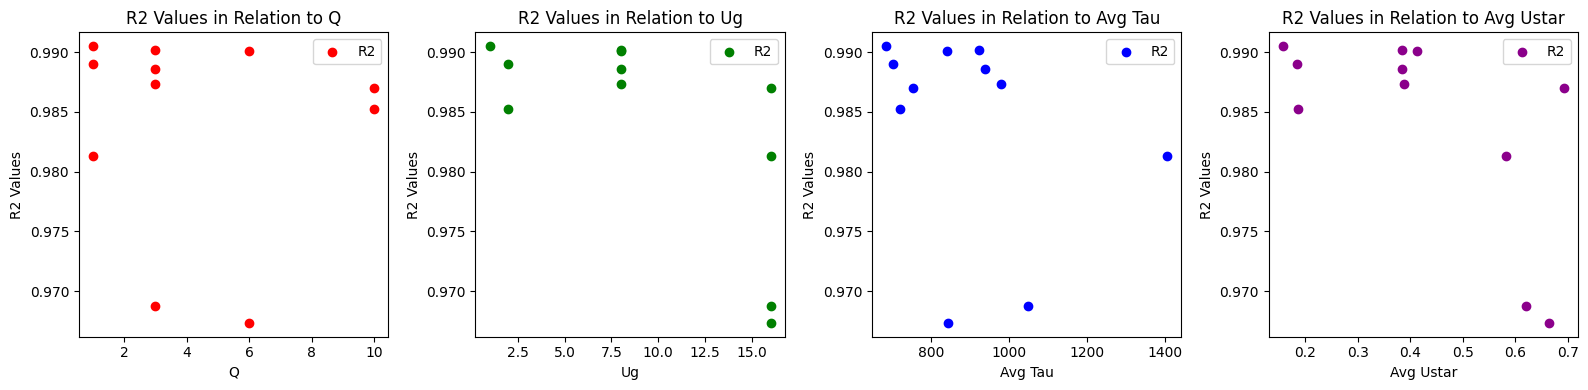

In [15]:
###### Is there any relationship between fit and the forcings??? ################
plt.figure(figsize=(16, 4))

# Plot R2 vs. Q
plt.subplot(1, 4, 1)
plt.scatter(df_coefs['Q'], df_coefs['R2'], label='R2', marker='o', color='red')
plt.xlabel('Q')
plt.ylabel('R2 Values')
plt.title('R2 Values in Relation to Q')
plt.legend()

# Plot R2 vs. Ug
plt.subplot(1, 4, 2)
plt.scatter(df_coefs['Ug'], df_coefs['R2'], label='R2', marker='o', color='green')
plt.xlabel('Ug')
plt.ylabel('R2 Values')
plt.title('R2 Values in Relation to Ug')
plt.legend()

# Plot R2 vs. Avg Tau
plt.subplot(1, 4, 3)
plt.scatter(df_coefs['Avg Tau'], df_coefs['R2'], label='R2', marker='o', color='blue')
plt.xlabel('Avg Tau')
plt.ylabel('R2 Values')
plt.title('R2 Values in Relation to Avg Tau')
plt.legend()

# Plot R2 vs. Avg Ustar
plt.subplot(1, 4, 4)
plt.scatter(df_coefs['Avg Ustar'], df_coefs['R2'], label='R2', marker='o', color='darkmagenta')
plt.xlabel('Avg Ustar')
plt.ylabel('R2 Values')
plt.title('R2 Values in Relation to Avg Ustar')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


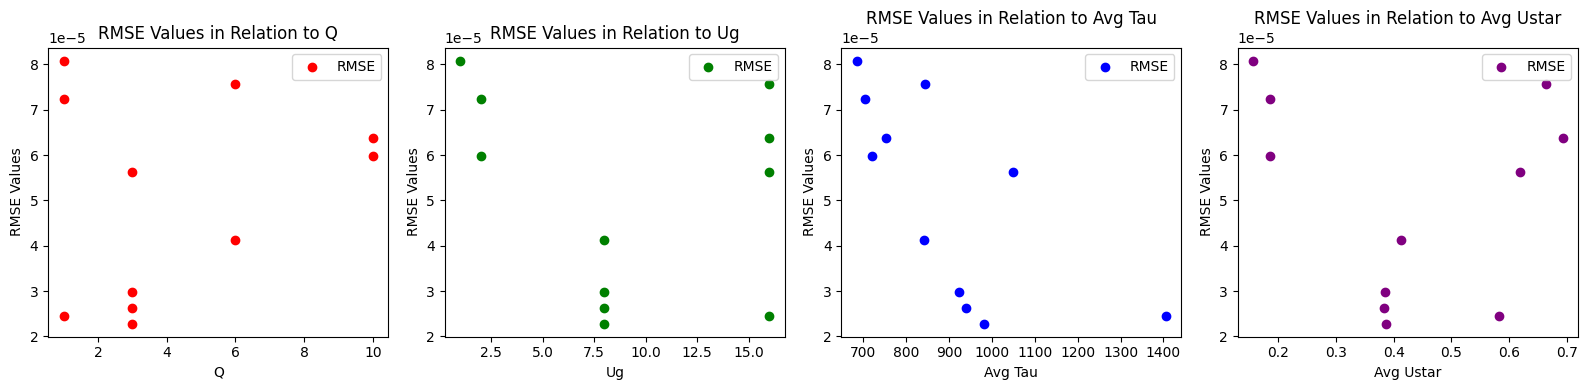

In [16]:
###### Is there any relationship between fit and the forcings??? ################
plt.figure(figsize=(16, 4))

# Plot RMSE vs. Q
plt.subplot(1, 4, 1)
plt.scatter(df_coefs['Q'], df_coefs['RMSE'], label='RMSE', marker='o', color='red')
plt.xlabel('Q')
plt.ylabel('RMSE Values')
plt.title('RMSE Values in Relation to Q')
plt.legend()

# Plot RMSE vs. Ug
plt.subplot(1, 4, 2)
plt.scatter(df_coefs['Ug'], df_coefs['RMSE'], label='RMSE', marker='o', color='green')
plt.xlabel('Ug')
plt.ylabel('RMSE Values')
plt.title('RMSE Values in Relation to Ug')
plt.legend()

# Plot RMSE vs. Avg Tau
plt.subplot(1, 4, 3)
plt.scatter(df_coefs['Avg Tau'], df_coefs['RMSE'], label='RMSE', marker='o', color='blue')
plt.xlabel('Avg Tau')
plt.ylabel('RMSE Values')
plt.title('RMSE Values in Relation to Avg Tau')
plt.legend()

# Plot RMSE vs. Avg Ustar
plt.subplot(1, 4, 4)
plt.scatter(df_coefs['Avg Ustar'], df_coefs['RMSE'], label='RMSE', marker='o', color='purple')
plt.xlabel('Avg Ustar')
plt.ylabel('RMSE Values')
plt.title('RMSE Values in Relation to Avg Ustar')
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


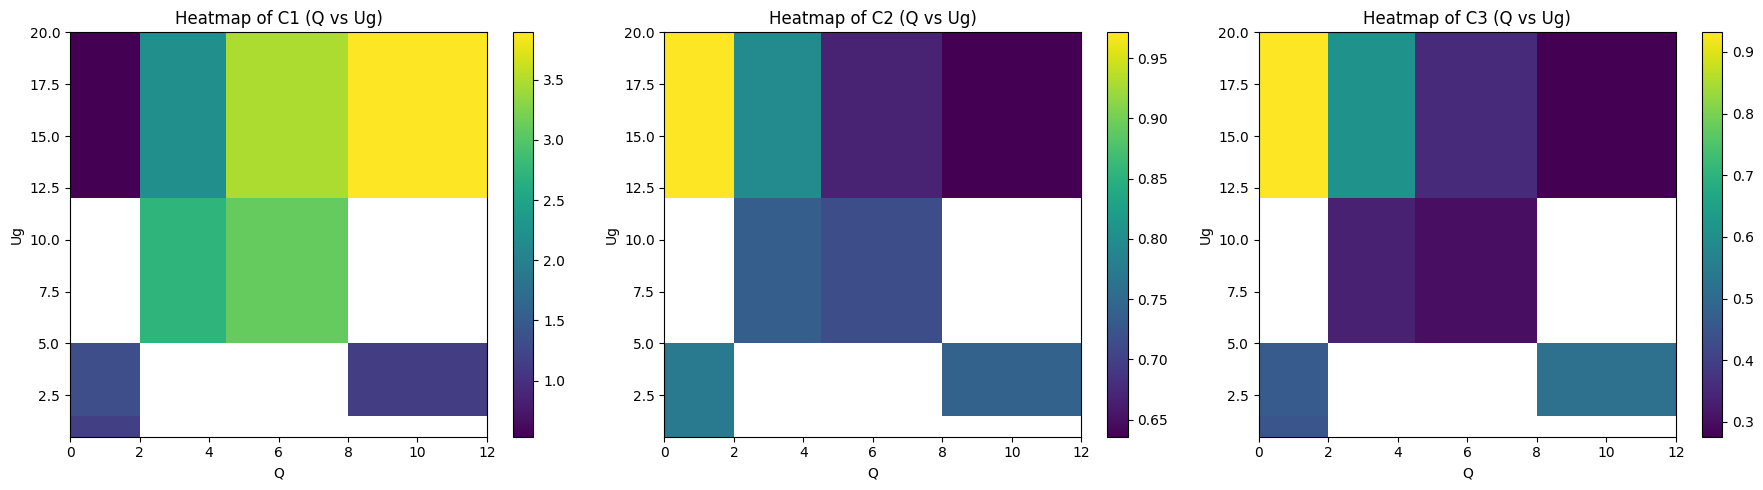

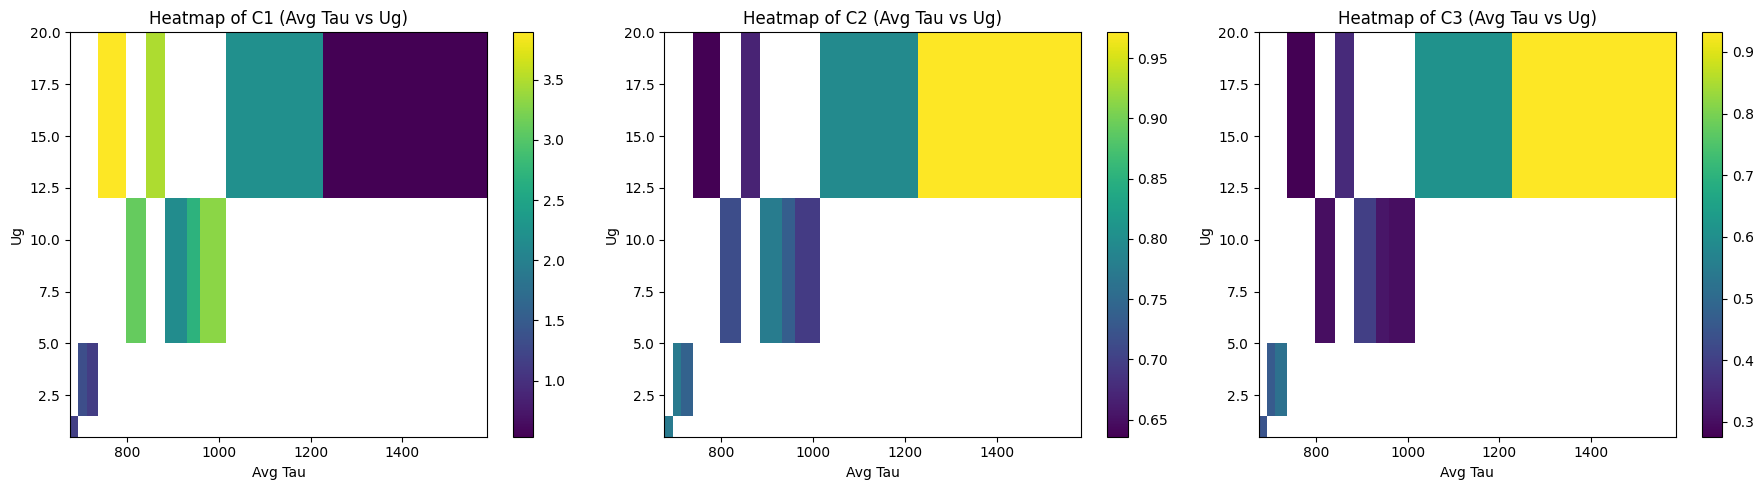

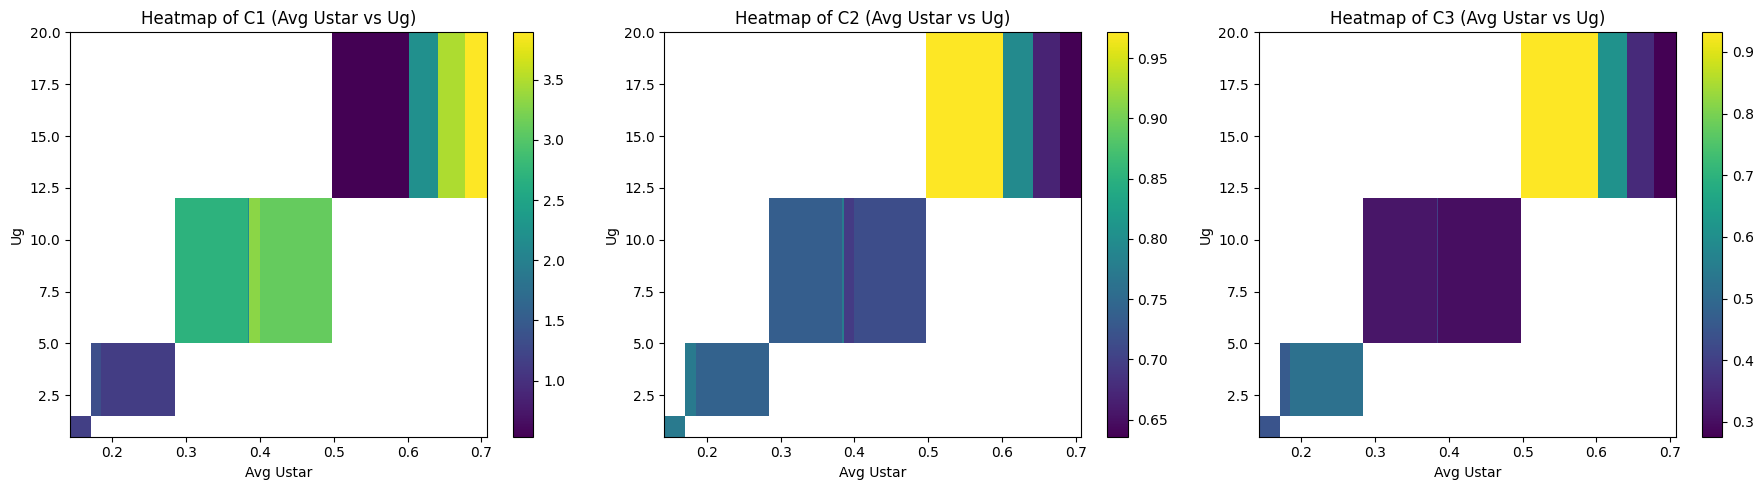

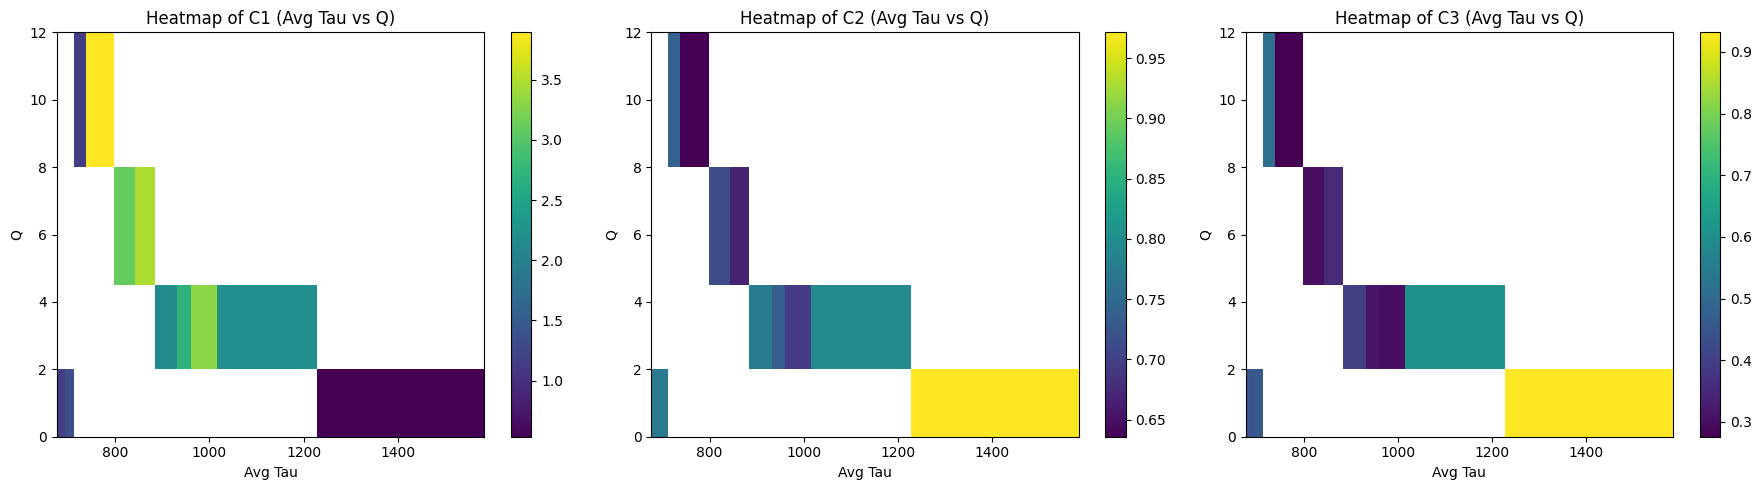

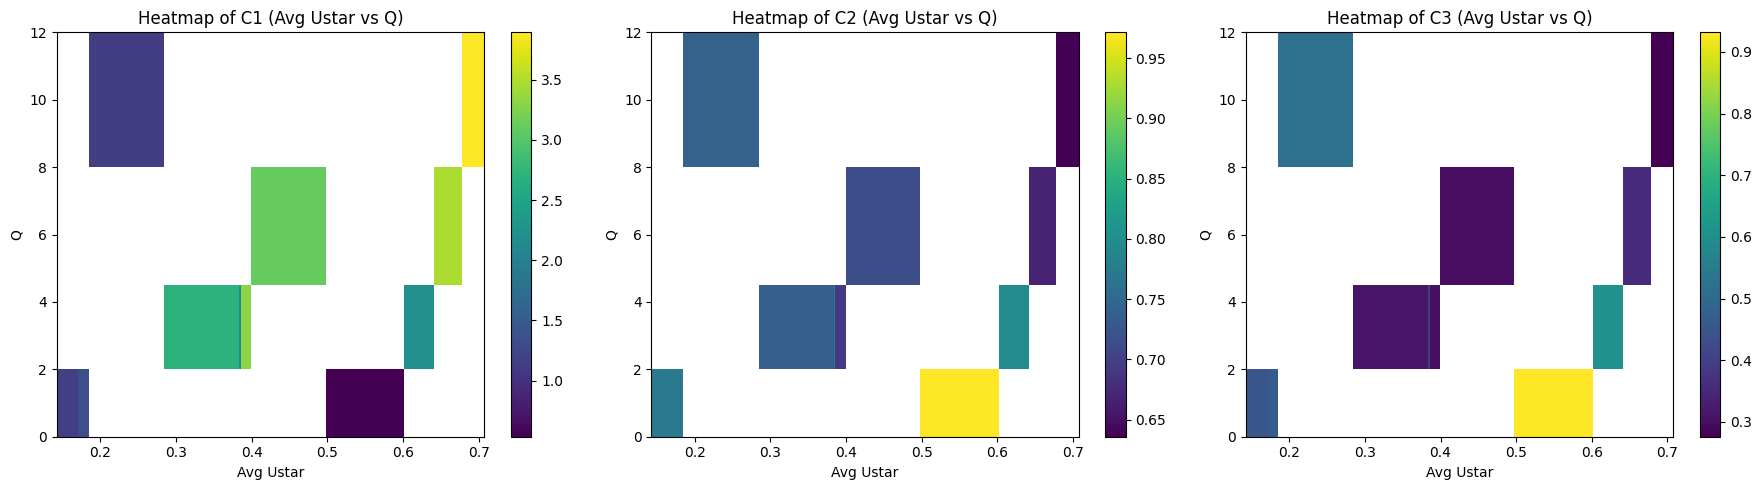

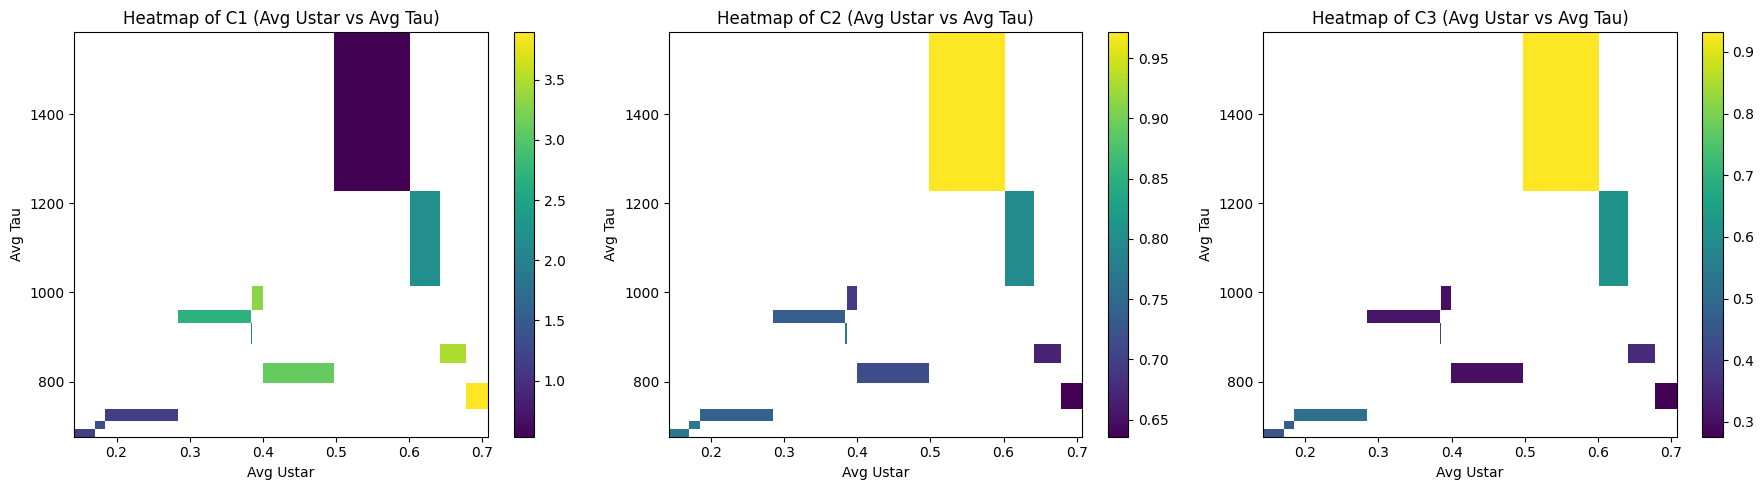

In [17]:
# Define the variable pairs and their respective labels
variable_pairs = [
    ('Ug', 'Q'), 
    ('Ug', 'Avg Tau'), 
    ('Ug', 'Avg Ustar'), 
    ('Q', 'Avg Tau'), 
    ('Q', 'Avg Ustar'), 
    ('Avg Tau', 'Avg Ustar')
]

xlabel_pairs = [
    ('Q', 'Ug'), 
    ('Avg Tau', 'Ug'), 
    ('Avg Ustar', 'Ug'), 
    ('Avg Tau', 'Q'), 
    ('Avg Ustar', 'Q'), 
    ('Avg Ustar', 'Avg Tau')
]

# Function to create heatmap
def create_heatmap(ax, x_grid, y_grid, C, xlabel, ylabel, title):
    heatmap = ax.pcolormesh(x_grid, y_grid, C, shading='auto', cmap='viridis')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.colorbar(heatmap, ax=ax)

# Loop through each variable pair to create the plots
for (var1, var2), (xlabel, ylabel) in zip(variable_pairs, xlabel_pairs):
    # Pivot tables to create 2D arrays
    C1_grid = df_coefs.pivot_table(index=var1, columns=var2, values='C1')
    C2_grid = df_coefs.pivot_table(index=var1, columns=var2, values='C2')
    C3_grid = df_coefs.pivot_table(index=var1, columns=var2, values='C3')

    # Create a meshgrid for var1 and var2
    x_values = C1_grid.columns
    y_values = C1_grid.index
    x_grid, y_grid = np.meshgrid(x_values, y_values)

    # Plot the heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    create_heatmap(axes[0], x_grid, y_grid, C1_grid.values, xlabel, ylabel, f'Heatmap of C1 ({xlabel} vs {ylabel})')
    create_heatmap(axes[1], x_grid, y_grid, C2_grid.values, xlabel, ylabel, f'Heatmap of C2 ({xlabel} vs {ylabel})')
    create_heatmap(axes[2], x_grid, y_grid, C3_grid.values, xlabel, ylabel, f'Heatmap of C3 ({xlabel} vs {ylabel})')

    plt.tight_layout()
    plt.show()



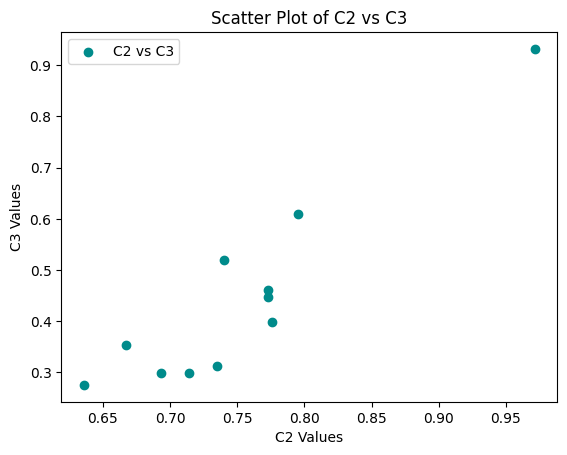

In [18]:
# Scatter plot of C2 and C3
# plt.figure(figsize=(7, 4))
plt.scatter(df_coefs['C2'], df_coefs['C3'], marker='o', color='darkcyan', label='C2 vs C3')

# Adding labels and title
plt.xlabel('C2 Values')
plt.ylabel('C3 Values')
plt.title('Scatter Plot of C2 vs C3')
plt.legend()

# Show the plot
plt.show()


In [17]:
df_coefs

,File,Avg Ustar,Avg Tau,Ug,Q,RMSE,R2,C1,C2,C3,Inversion Strength
0,Ug16Q001_IV.nc,0.583217,1405.862176,16,1,0.000024,0.981304,0.534015,0.971441,0.931903,4
1,Ug16Q003_IV.nc,0.619608,1049.518786,16,3,0.000056,0.968710,2.200838,0.794898,0.608740,4
2,Ug16Q006_IV.nc,0.663322,843.801678,16,6,0.000076,0.967333,3.480432,0.667441,0.352913,4
3,Ug16Q010_IV.nc,0.692744,753.947342,16,10,0.000064,0.986968,3.892732,0.635783,0.275732,4
4,Ug1Q01_II.nc,0.156549,685.283322,1,1,0.000081,0.990494,1.160933,0.772905,0.447008,2
5,Ug2Q010_IV.nc,0.185135,721.373486,2,10,0.000060,0.985244,1.130810,0.739922,0.519088,4
6,Ug2Q01_III.nc,0.184706,703.534752,2,1,0.000072,0.988998,1.330275,0.773037,0.461213,3
7,Ug8Q003_II.nc,0.384079,923.887276,8,3,0.000030,0.990180,2.158704,0.775836,0.398563,2
8,Ug8Q003_III.nc,0.383418,939.150159,8,3,0.000026,0.988617,2.686453,0.735105,0.312753,3
9,Ug8Q003_IV.nc,0.387227,980.796441,8,3,0.000023,0.987343,3.306518,0.693531,0.299167,4


In [18]:
df_augment = df_coefs[['Avg Ustar', 'Avg Tau', 'Ug', 'Q', 'C1', 'C2', 'C3']]

# Function to add Gaussian noise
def add_noise(data, mean=0, std=0.1):
    noise = np.random.normal(mean, std, data.shape)
    return data + noise

# Number of synthetic data points to generate
num_synthetic = 89  # To reach approximately 100 points in total

synthetic_data = pd.DataFrame(columns=df_augment.columns)

synthetic_data

for _ in range(num_synthetic//len(df_augment)):
    noisy_data = add_noise(df_augment)
    synthetic_data = pd.concat([synthetic_data, noisy_data], ignore_index=True)

# Combine original and synthetic data
augmented_df = pd.concat([df_augment, synthetic_data], ignore_index=True).reset_index(drop=True)

C:\Users\anton\AppData\Local\Temp\ipykernel_19196\84904326.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  synthetic_data = pd.concat([synthetic_data, noisy_data], ignore_index=True)


No normalization applied
Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 1.590e+05
Head worker occupation: 25.5%
Progress: 485 / 15000 total iterations (3.233%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.163e+00  1.594e+01  y = 2.2523
3           1.035e+00  5.842e-02  y = Ustar + 1.8111
4           7.085e-01  3.789e-01  y = exp(cos(inv(Q_ic)))
5           5.811e-01  1.983e-01  y = 3.2 + (-2.1398 / Q_ic)
7           5.222e-01  5.344e-02  y = (-2.0082 / Q_ic) + (2.7004 + Ustar)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.520e+05
Head worker occupation: 26.3%
Progress: 986 / 15000 total iterations (6.573%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation

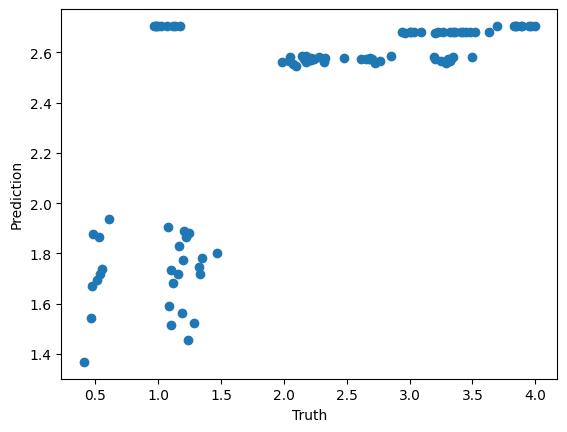

No normalization applied


[ Info: Started!



Expressions evaluated per second: 1.520e+05
Head worker occupation: 22.8%
Progress: 541 / 15000 total iterations (3.607%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.898e-02  1.594e+01  y = 0.76516
5           1.412e-02  7.406e-02  y = 0.44965 - (Tau * -0.00035238)
7           1.357e-02  1.976e-02  y = (0.00057273 * Tau) + (217.3 / Tau)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.730e+05
Head worker occupation: 21.7%
Progress: 1169 / 15000 total iterations (7.793%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.898e-02  1.594e+01  y = 0.76516
5           1.412e-02  7.406e-02  y = 0.44966 - (Tau * -

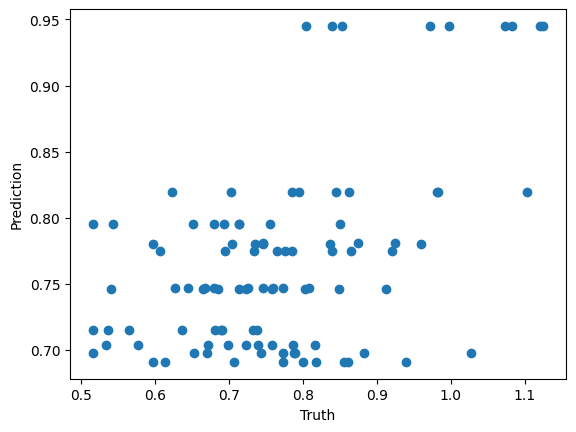

No normalization applied


[ Info: Started!



Expressions evaluated per second: 2.140e+05
Head worker occupation: 17.1%
Progress: 669 / 15000 total iterations (4.460%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.747e-02  1.594e+01  y = 0.45911
3           2.475e-02  2.072e-01  y = 0.00051556 * Tau
5           1.950e-02  1.192e-01  y = 0.28044 + (Ustar / Q_ic)
7           1.749e-02  5.446e-02  y = (0.24428 / Q_ic) + (0.00039596 * Tau)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.240e+05
Head worker occupation: 17.5%
Progress: 1349 / 15000 total iterations (8.993%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.747e-02  1.594e+01  y = 0.45911
3  

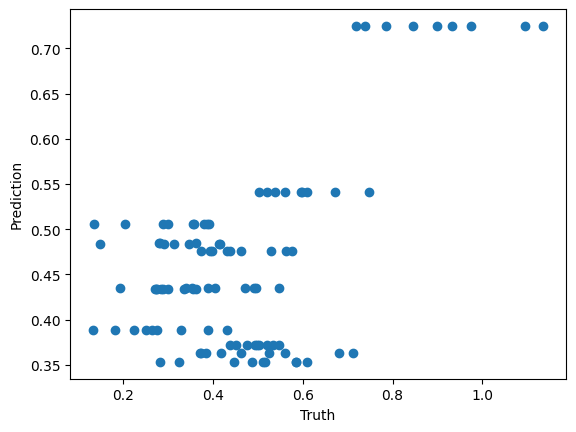

In [19]:
model_C1_none, eq_C1_none = discover_coef_eqs(augmented_df, normChoice = "none", coefficient = "C1")
model_C2_none, eq_C2_none = discover_coef_eqs(augmented_df, normChoice = "none", coefficient = "C2")
model_C3_none, eq_C3_none = discover_coef_eqs(augmented_df, normChoice = "none", coefficient = "C3")

Don't forget to unnormalize the coef (zscore)


[ Info: Started!



Expressions evaluated per second: 2.210e+05
Head worker occupation: 15.7%
Progress: 719 / 15000 total iterations (4.793%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           9.899e-01  1.594e+01  y = 1.472e-05
2           7.630e-01  2.603e-01  y = sin(Q_ic)
3           5.323e-01  3.601e-01  y = Ug - Tau
4           3.094e-01  5.427e-01  y = cos(Ug + Tau)
5           1.834e-01  5.227e-01  y = 0.58837 - (Ug * Tau)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.200e+05
Head worker occupation: 14.9%
Progress: 1430 / 15000 total iterations (9.533%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           9.899e-01  1.594e+01  y

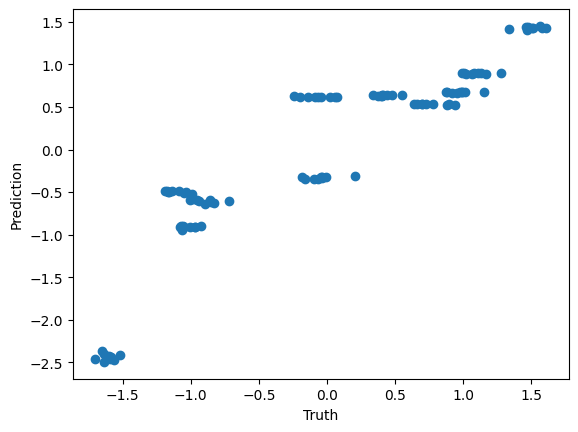

Don't forget to unnormalize the coef (zscore)


[ Info: Started!



Expressions evaluated per second: 2.340e+05
Head worker occupation: 18.8%
Progress: 716 / 15000 total iterations (4.773%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           9.773e-01  1.594e+01  y = Tau
2           9.251e-01  5.495e-02  y = sin(Tau)
3           7.361e-01  2.285e-01  y = 0.50635 * Tau
5           6.681e-01  4.845e-02  y = cos(Q_ic) - cos(Tau)
6           6.644e-01  5.656e-03  y = exp(Ug) * (0.20803 * Tau)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.240e+05
Head worker occupation: 17.5%
Progress: 1452 / 15000 total iterations (9.680%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           9.773e-01  1.

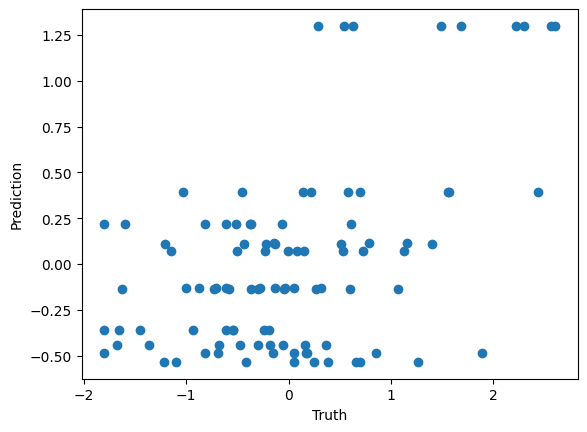

Don't forget to unnormalize the coef (zscore)


[ Info: Started!



Expressions evaluated per second: 2.150e+05
Head worker occupation: 16.4%
Progress: 672 / 15000 total iterations (4.480%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           8.205e-01  1.594e+01  y = Tau
3           6.500e-01  1.165e-01  y = cos(inv(Tau))
4           5.172e-01  2.286e-01  y = cube(Tau * 0.5121)
5           4.135e-01  2.239e-01  y = (Ug * Tau) - 0.58842
7           3.716e-01  5.341e-02  y = (Tau * 0.51119) / (Ug + -0.62123)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.110e+05
Head worker occupation: 16.7%
Progress: 1345 / 15000 total iterations (8.967%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1      

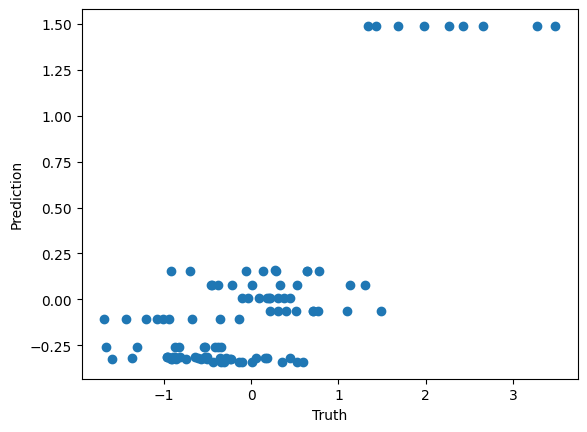

In [20]:
model_C1_zscore, eq_C1_zscore = discover_coef_eqs(augmented_df, normChoice = "zscore", coefficient = "C1")
model_C2_zscore, eq_C2_zscore = discover_coef_eqs(augmented_df, normChoice = "zscore", coefficient = "C2")
model_C3_zscore, eq_C3_zscore = discover_coef_eqs(augmented_df, normChoice = "zscore", coefficient = "C3")

Don't forget to unnormalize the coef (minmax)


[ Info: Started!



Expressions evaluated per second: 1.830e+05
Head worker occupation: 18.6%
Progress: 657 / 15000 total iterations (4.380%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           9.043e-02  1.594e+01  y = 0.51365
2           8.539e-02  5.737e-02  y = sin(Ustar)
3           8.340e-02  2.354e-02  y = sin(sin(Ustar))
4           4.749e-02  5.632e-01  y = sin(Q_ic * 2.5832)
5           4.465e-02  6.166e-02  y = (Q_ic * Ug) - -0.29189
6           3.486e-02  2.473e-01  y = (0.12518 + Ustar) - cube(Tau)
7           2.505e-02  3.306e-01  y = (Ug + 0.18843) - (Ug * Tau)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.800e+05
Head worker occupation: 17.5%
Progress: 1302 / 15000 total iterations (8.680%)
Hall of Fame:
------------------------------

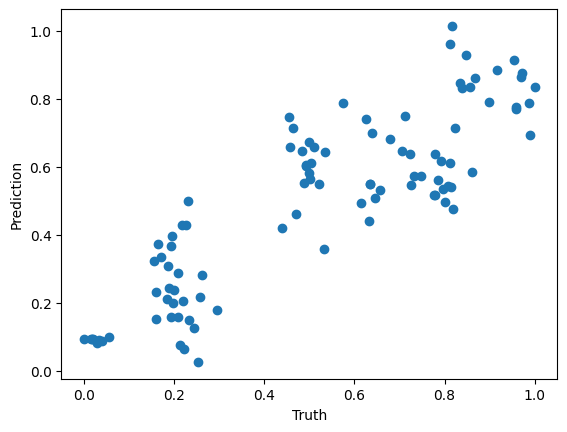

Don't forget to unnormalize the coef (minmax)


[ Info: Started!



Expressions evaluated per second: 1.590e+05
Head worker occupation: 21.8%
Progress: 576 / 15000 total iterations (3.840%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           5.101e-02  1.594e+01  y = 0.40929
4           3.686e-02  1.083e-01  y = exp(Tau + -1.2395)
5           3.633e-02  1.442e-02  y = 0.54792 / (1.7098 - Tau)
6           3.553e-02  2.214e-02  y = cos(Q_ic) / (2.4731 - Tau)
7           3.508e-02  1.284e-02  y = (Tau + 0.86448) / (Q_ic + 2.5057)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.650e+05
Head worker occupation: 21.7%
Progress: 1117 / 15000 total iterations (7.447%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score

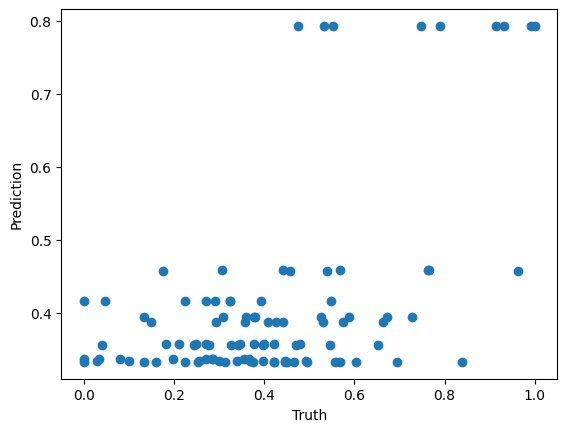

Don't forget to unnormalize the coef (minmax)


[ Info: Started!



Expressions evaluated per second: 1.860e+05
Head worker occupation: 16.7%
Progress: 613 / 15000 total iterations (4.087%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.706e-02  1.594e+01  y = 0.32617
4           1.809e-02  2.390e-01  y = 1.2501 - cos(Tau)
5           1.809e-02  -0.000e+00  y = exp(0.22317) - cos(Tau)
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.890e+05
Head worker occupation: 19.8%
Progress: 1233 / 15000 total iterations (8.220%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           3.706e-02  1.594e+01  y = 0.32617
4           1.809e-02  2.390e-01  y = 1.25 - cos(Tau)
------------------------

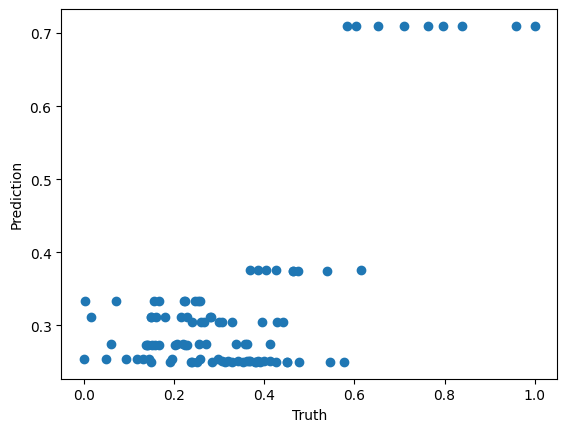

In [21]:
model_C1_minmax, eq_C1_minmax = discover_coef_eqs(augmented_df, normChoice = "minmax", coefficient = "C1")
model_C2_minmax, eq_C2_minmax = discover_coef_eqs(augmented_df, normChoice = "minmax", coefficient = "C2")
model_C3_minmax, eq_C3_minmax = discover_coef_eqs(augmented_df, normChoice = "minmax", coefficient = "C3")

In [22]:
eq_C1_minmax.iloc[6,4]

(1.0510674 - Tau)*(Tau + Ustar)

In [23]:
eq_C1_minmax

,complexity,loss,score,equation,sympy_format,lambda_format
0,1,0.090430,0.000000,0.51364905,0.513649050000000,PySRFunction(X=>0.513649050000000)
1,2,0.085388,0.057372,sin(Ustar),sin(Ustar),PySRFunction(X=>sin(Ustar))
2,3,0.083401,0.023544,sin(sin(Ustar)),sin(sin(Ustar)),PySRFunction(X=>sin(sin(Ustar)))
3,4,0.047487,0.563198,sin(2.583235 * Q_ic),sin(2.583235*Q_ic),PySRFunction(X=>sin(2.583235*Q_ic))
4,5,0.036267,0.269562,(Q_ic * Tau) * 6.7110105,6.7110105*Q_ic*Tau,PySRFunction(X=>6.7110105*Q_ic*Tau)
5,6,0.034406,0.052660,(6.8590317 * Q_ic) * sin(Tau),6.8590317*Q_ic*sin(Tau),PySRFunction(X=>6.8590317*Q_ic*sin(Tau))
6,7,0.022970,0.404037,(Tau + Ustar) * (1.0510674 - Tau),(1.0510674 - Tau)*(Tau + Ustar),PySRFunction(X=>(1.0510674 - Tau)*(Tau + Ustar))


other things to think abt: 
- ustar in front of third term (punished coefficient complexity) (think abt)
- parametrization for dwwtheta/dz
- direct parametrization for wtheta (hard)

final presi will be: 
1. the problem (background on turbulence, atmospheric boundary layer, etc)
2. the methodology (PYSR, how does it work, genetic algorithms, etc)
3. Re-disovery of the original equation.
4. Current work on improving the parametrization.